In [300]:
from collections import defaultdict, namedtuple, Counter
import sys
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats


In [301]:
#phase_dir = '../phased_ancestry_quads'
#build = '37'
#phenotype = ''

phase_dir = '../phased_spark_quads'
build = '38'

chroms = [str(x) for x in range(1, 23)]
name = 'cyto'


In [302]:
cyto = []
with open('../data/cytoBand%s.txt' % build, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0].startswith('chr') and pieces[0][3:] in chroms:
            cyto.append((pieces[0][3:], int(pieces[1]), int(pieces[2]), pieces[3], pieces[4]))

chrom_to_start_pos = [1]
for chrom in chroms[:-1]:
    chrom_length = max([x[2] for x in cyto if x[0]==chrom])
    chrom_to_start_pos.append(chrom_to_start_pos[-1] + chrom_length)
    

In [303]:
all_chroms, all_regions = [], []
mat_pvalues, pat_pvalues, combined_pvalues = [], [], []
contingency = []
for i, chrom in enumerate(chroms):
    regions = np.load('%s/chr.%s.recomb.pvalues.intervals.%s.regions.npy' % (phase_dir, chrom, name))
    all_chroms.append(i*np.ones((regions.shape[0],), dtype=int))
    all_regions.append(regions)
    p = np.load('%s/chr.%s.recomb.pvalues.intervals.%s.npy' % (phase_dir, chrom, name))
    r = np.load('%s/chr.%s.recomb.pvalues.intervals.%s.contingency.npy' % (phase_dir, chrom, name))
    
    mat_pvalues.append(p[:, 0, :])
    pat_pvalues.append(p[:, 1, :])
    combined_pvalues.append(p[:, 2, :])
    contingency.append(r)
    
all_chroms = np.hstack(all_chroms)
all_regions = np.vstack(all_regions)
contingency = np.vstack(contingency)

mat_pvalues = np.vstack(mat_pvalues)
pat_pvalues = np.vstack(pat_pvalues)
combined_pvalues = np.vstack(combined_pvalues)


print(all_regions.shape, combined_pvalues.shape, contingency.shape)


(3244, 2) (3244, 3) (3244, 3, 2, 2)


In [304]:
#include_in_display = np.zeros(all_positions.shape, dtype=bool)
#include_in_display[0] = True
#last_pos = all_positions[0]
#for i, pos in enumerate(all_positions):
#    if np.abs(pos - last_pos) > cutoff:
#        include_in_display[i] = True
#        last_ps = pos

include_in_display = np.ones((all_regions.shape[0]), dtype=bool)
#for c in cyto:
#    if c[0] in chroms and c[-1] == 'acen':
#        include_in_display[(all_chroms==chroms.index(c[0])) & (np.minimum(all_regions[:, 1], c[2])-np.maximum(all_regions[:, 0], c[1])>0)]=False
print('including', np.sum(include_in_display)/include_in_display.shape[0])



including 1.0


In [305]:
bonferonni_cutoff = -np.log10(0.05/(3*np.sum(include_in_display)))
print(bonferonni_cutoff)

5.289232095922762


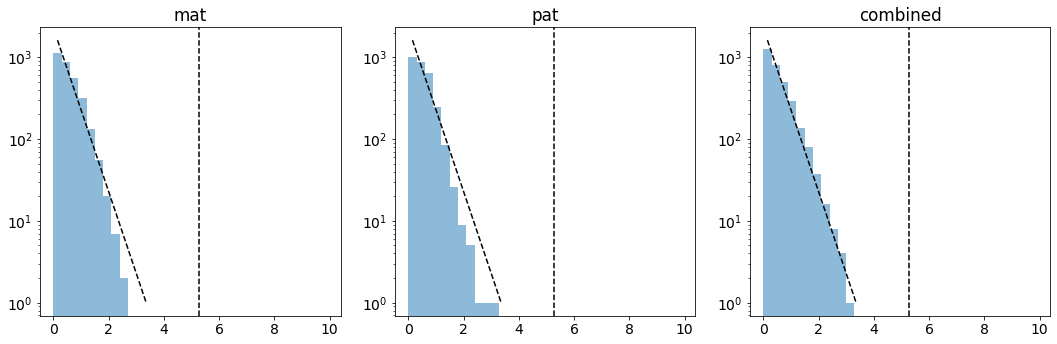

In [306]:
binsize = 0.3
x_chrom = -1 if 'X' not in chroms else chroms.index('X')
n = np.sum(include_in_display & (all_chroms != x_chrom))

def plot_pvalue_dist(pvalues):
    plt.hist(np.clip(-np.log10(pvalues[include_in_display & (all_chroms != x_chrom), 0]), None, 9), 
                     log=True, bins=np.arange(0, 10, binsize), alpha=0.5)

    plt.plot([binsize/2, np.log10(n*(1-(10**-binsize))) + binsize/2], 
             [n*(1-(10**-binsize)), 1], color='black', linestyle='--')  
    plt.axvline(bonferonni_cutoff, color='black', linestyle='--')

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plot_pvalue_dist(mat_pvalues)
plt.title('mat')#

plt.subplot(1, 3, 2)
plot_pvalue_dist(pat_pvalues)
plt.title('pat')

plt.subplot(1, 3, 3)
plot_pvalue_dist(combined_pvalues)
plt.title('combined')

plt.tight_layout()
plt.show()

In [307]:
xs = np.array([p+chrom_to_start_pos[c] for p, c in zip(all_regions[:, 0], all_chroms)])


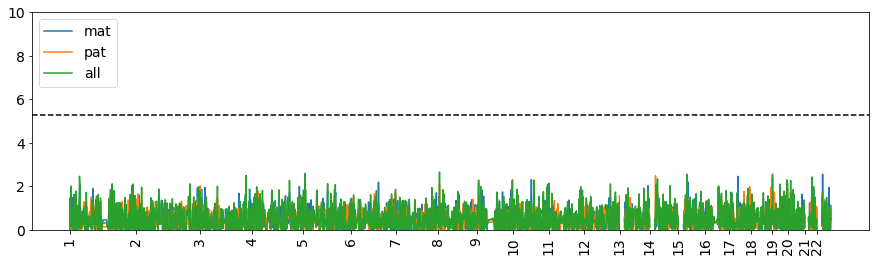

In [308]:
import matplotlib
plt.figure(figsize=(15, 4))
matplotlib.rcParams.update({'font.size': 14})

index = 1
plt.plot(xs[include_in_display], -np.log10(mat_pvalues[include_in_display, index]), label='mat')
plt.plot(xs[include_in_display], -np.log10(pat_pvalues[include_in_display, index]), label='pat')
plt.plot(xs[include_in_display], -np.log10(combined_pvalues[include_in_display, index]), label='all')
plt.ylim([0, 10])

plt.xticks(chrom_to_start_pos, chroms, rotation=90)
plt.axhline(bonferonni_cutoff, color='black', linestyle='--')
plt.legend(loc='upper left')
plt.show()

In [309]:
#print('simplex combined')
#indices = -np.log10(simplex_combined_pvalues)>bonferonni_cutoff
#start_indices, end_indices = np.where(~indices[:-1] & indices[1:])[0], np.where(indices[:-1] & ~indices[1:])[0]+1
#for start_index, end_index in zip(start_indices, end_indices):
#    print('%s:%d-%d (hg%s)' % (chroms[all_chroms[start_index]], all_regions[start_index, 0], all_regions[end_index, 1], build))

#print('\nmultiplex combined')
#indices = -np.log10(multiplex_combined_pvalues)>bonferonni_cutoff
#start_indices, end_indices = np.where(~indices[:-1] & indices[1:])[0], np.where(indices[:-1] & ~indices[1:])[0]+1
#for start_index, end_index in zip(start_indices, end_indices):
#    print('%s:%d-%d (hg%s)' % (chroms[all_chroms[start_index]], all_regions[start_index, 0], all_regions[end_index, 1], build))

indices = -np.log10(combined_pvalues)>bonferonni_cutoff
start_indices, end_indices = np.where(~indices[:-1] & indices[1:])[0]+1, np.where(indices[:-1] & ~indices[1:])[0]
for start_index, end_index in zip(start_indices, end_indices):
    if all_chroms[start_index] == all_chroms[end_index]:
        print(start_index, end_index, -np.log10(combined_pvalues[start_index]), -np.log10(combined_pvalues[end_index]), bonferonni_cutoff)
        print('%s:%d-%d (hg%s)' % (chroms[all_chroms[start_index]], all_regions[start_index, 0], all_regions[end_index, 1], build))
    
#print('\nmultiplex pat')
#indices = -np.log10(multiplex_pat_pvalues)>bonferonni_cutoff-0.5
#start_indices, end_indices = np.where(~indices[:-1] & indices[1:])[0], np.where(indices[:-1] & ~indices[1:])[0]+1
#for start_index, end_index in zip(start_indices, end_indices):
#    print('%s:%d-%d (hg%s)' % (chroms[all_chroms[start_index]], all_regions[start_index, 0], all_regions[end_index, 1], build))


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater


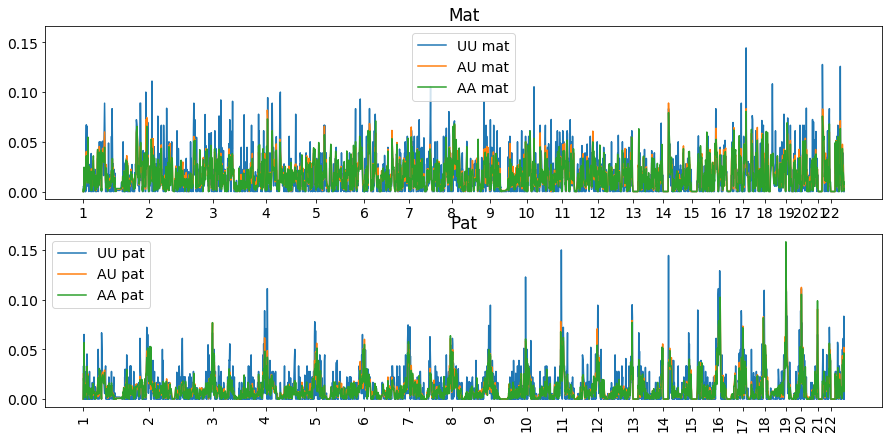

In [310]:
import matplotlib
plt.figure(figsize=(15, 7))
matplotlib.rcParams.update({'font.size': 14})

ax = plt.subplot(2, 1, 1)
plt.plot(xs[include_in_display], contingency[include_in_display, 0, 0, 1]/(2*np.sum(contingency[include_in_display, 0, 0, :], axis=1)), label='UU mat')
plt.plot(xs[include_in_display], contingency[include_in_display, 1, 0, 1]/(2*np.sum(contingency[include_in_display, 1, 0, :], axis=1)), label='AU mat')
plt.plot(xs[include_in_display], contingency[include_in_display, 2, 0, 1]/(2*np.sum(contingency[include_in_display, 2, 0, :], axis=1)), label='AA mat')
plt.title('Mat')
plt.legend()

plt.subplot(2, 1, 2, sharex=ax, sharey=ax)
plt.plot(xs[include_in_display], contingency[include_in_display, 0, 1, 1]/(2*np.sum(contingency[include_in_display, 0, 1, :], axis=1)), label='UU pat')
plt.plot(xs[include_in_display], contingency[include_in_display, 1, 1, 1]/(2*np.sum(contingency[include_in_display, 1, 1, :], axis=1)), label='AU pat')
plt.plot(xs[include_in_display], contingency[include_in_display, 2, 1, 1]/(2*np.sum(contingency[include_in_display, 2, 1, :], axis=1)), label='AA pat')
plt.title('Pat')
plt.legend()

plt.xticks(chrom_to_start_pos, chroms, rotation=90)
plt.show()

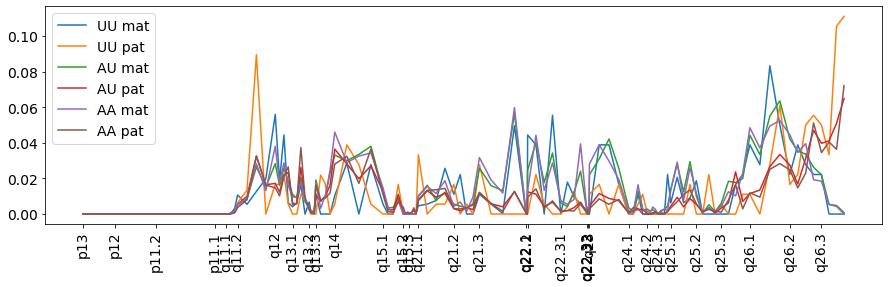

In [311]:
chrom = '15'
chrom_index = chroms.index(chrom)

plt.figure(figsize=(15, 4))

plt.plot(xs[include_in_display & (all_chroms==chrom_index)], 
         contingency[include_in_display & (all_chroms==chrom_index), 0, 0, 1]/(2*np.sum(contingency[include_in_display & (all_chroms==chrom_index), 0, 0, :], axis=1)), label='UU mat')
plt.plot(xs[include_in_display & (all_chroms==chrom_index)], 
         contingency[include_in_display & (all_chroms==chrom_index), 0, 1, 1]/(2*np.sum(contingency[include_in_display & (all_chroms==chrom_index), 0, 1, :], axis=1)), label='UU pat')
plt.plot(xs[include_in_display & (all_chroms==chrom_index)], 
         contingency[include_in_display & (all_chroms==chrom_index), 1, 0, 1]/(2*np.sum(contingency[include_in_display & (all_chroms==chrom_index), 1, 0, :], axis=1)), label='AU mat')
plt.plot(xs[include_in_display & (all_chroms==chrom_index)],
         contingency[include_in_display & (all_chroms==chrom_index), 1, 1, 1]/(2*np.sum(contingency[include_in_display & (all_chroms==chrom_index), 1, 1, :], axis=1)), label='AU pat')
plt.plot(xs[include_in_display & (all_chroms==chrom_index)], 
         contingency[include_in_display & (all_chroms==chrom_index), 2, 0, 1]/(2*np.sum(contingency[include_in_display & (all_chroms==chrom_index), 2, 0, :], axis=1)), label='AA mat')
plt.plot(xs[include_in_display & (all_chroms==chrom_index)], 
         contingency[include_in_display & (all_chroms==chrom_index), 2, 1, 1]/(2*np.sum(contingency[include_in_display & (all_chroms==chrom_index), 2, 1, :], axis=1)), label='AA pat')
#plt.ylim([0, 10])

plt.xticks([chrom_to_start_pos[chrom_index]+x[1] for x in cyto if x[0]==chrom], 
       [x[3] for x in cyto if x[0]==chrom], rotation=90)
plt.legend()
plt.show()

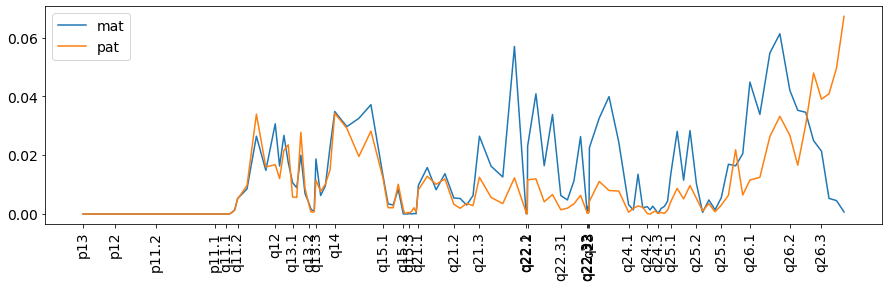

In [312]:
plt.figure(figsize=(15, 4))

plt.plot(xs[include_in_display & (all_chroms==chrom_index)], 
         np.sum(contingency[include_in_display & (all_chroms==chrom_index), :, 0, 1], axis=1)/(2*np.sum(contingency[include_in_display & (all_chroms==chrom_index), :, 0, :], axis=(1, 2))), label='mat')
plt.plot(xs[include_in_display & (all_chroms==chrom_index)], 
         np.sum(contingency[include_in_display & (all_chroms==chrom_index), :, 1, 1], axis=1)/(2*np.sum(contingency[include_in_display & (all_chroms==chrom_index), :, 1, :], axis=(1, 2))), label='pat')
#plt.ylim([0, 10])

plt.xticks([chrom_to_start_pos[chrom_index]+x[1] for x in cyto if x[0]==chrom], 
       [x[3] for x in cyto if x[0]==chrom], rotation=90)
plt.legend()
plt.show()

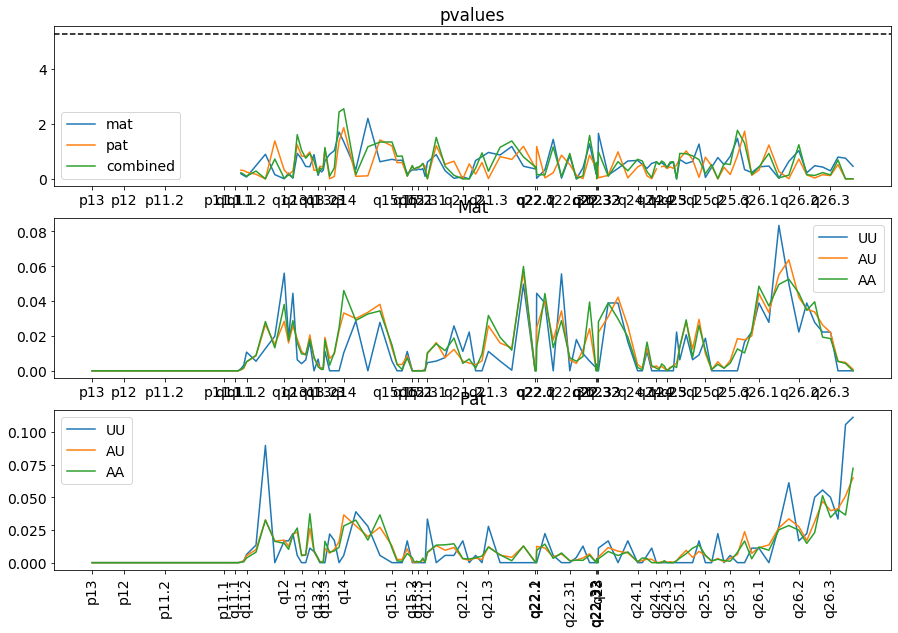

In [313]:
plt.figure(figsize=(15, 10))

ax = plt.subplot(3, 1, 1)

plt.plot(xs[include_in_display & (all_chroms==chrom_index)], 
         -np.log10(mat_pvalues[include_in_display & (all_chroms==chrom_index), index]), label='mat')
plt.plot(xs[include_in_display & (all_chroms==chrom_index)], 
         -np.log10(pat_pvalues[include_in_display & (all_chroms==chrom_index), index]), label='pat')
plt.plot(xs[include_in_display & (all_chroms==chrom_index)], 
         -np.log10(combined_pvalues[include_in_display & (all_chroms==chrom_index), index]), label='combined')
plt.axhline(bonferonni_cutoff, color='black', linestyle='--')
plt.title('pvalues')
plt.legend()

plt.subplot(3, 1, 2, sharex=ax)
plt.plot(xs[include_in_display & (all_chroms==chrom_index)], 
         contingency[include_in_display & (all_chroms==chrom_index), 0, 0, 1]/(2*np.sum(contingency[include_in_display & (all_chroms==chrom_index), 0, 0, :], axis=1)), label='UU')
plt.plot(xs[include_in_display & (all_chroms==chrom_index)], 
         contingency[include_in_display & (all_chroms==chrom_index), 1, 0, 1]/(2*np.sum(contingency[include_in_display & (all_chroms==chrom_index), 1, 0, :], axis=1)), label='AU')
plt.plot(xs[include_in_display & (all_chroms==chrom_index)], 
         contingency[include_in_display & (all_chroms==chrom_index), 2, 0, 1]/(2*np.sum(contingency[include_in_display & (all_chroms==chrom_index), 2, 0, :], axis=1)), label='AA')
plt.legend()
plt.title('Mat')

plt.subplot(3, 1, 3, sharex=ax)
plt.plot(xs[include_in_display & (all_chroms==chrom_index)], 
         contingency[include_in_display & (all_chroms==chrom_index), 0, 1, 1]/(2*np.sum(contingency[include_in_display & (all_chroms==chrom_index), 0, 1, :], axis=1)), label='UU')
plt.plot(xs[include_in_display & (all_chroms==chrom_index)], 
         contingency[include_in_display & (all_chroms==chrom_index), 1, 1, 1]/(2*np.sum(contingency[include_in_display & (all_chroms==chrom_index), 1, 1, :], axis=1)), label='AU')
plt.plot(xs[include_in_display & (all_chroms==chrom_index)], 
         contingency[include_in_display & (all_chroms==chrom_index), 2, 1, 1]/(2*np.sum(contingency[include_in_display & (all_chroms==chrom_index), 2, 1, :], axis=1)), label='AA')
plt.title('Pat')
#plt.ylim([0, 10])
plt.legend()

plt.xticks([chrom_to_start_pos[chrom_index]+x[1] for x in cyto if x[0]==chrom], 
       [x[3] for x in cyto if x[0]==chrom], rotation=90)

plt.show()